# Testing stock

* 時間, `最近成交價`, `當盤成交量`, `累積成交量`, `最佳五檔（賣價）`, `最佳五檔（賣量）`, `最佳五檔（買價）`, `最佳五檔（買量）`

In [1]:
import re
import numpy as np

def getDataset(path):
    dataset = []
    with open(path, 'r') as fp:
        for i in range(500):
            data = fp.readline()
            if len(data) == 0:
                break
            data = data.replace('-', '0')
            data = re.split(',|\n', data)[1:-1]
            data[3] = data[3].split('_')[0]
            data[4] = data[4].split('_')[0]
            data[5] = data[5].split('_')[0]
            data[6] = data[6].split('_')[0]
            try:
                dataset.append(np.asarray(data, dtype=np.float))
            except ValueError:
                print(data)
                
    return np.asarray(dataset)

# My own MinMaxScaler

In [2]:
class MinMaxScaler:
    __min = 0.
    __max = 1.
    __range = 1.
    __feature_range = (0, 1)
    __scale = 1.
    def __init__(self):
        pass
    def getScalerData(self, dataset, offset=0.1, feature_range=(0, 1)):
        data_max = np.max(dataset)
        data_min = np.min(dataset)
        if len(dataset) == 1:
            range_temp = dataset * offset
        else:
            range_temp = (data_max - data_min) * (1 + offset)
        self.__min = data_max - range_temp
        self.__max = data_min + range_temp
        self.__range = self.__max - self.__min
        self.__feature_range = feature_range
        self.__scale = (feature_range[1] - feature_range[0]) / self.__range
        return self.getTransformData(dataset)
    def getTransformData(self, dataset):
        return (dataset - self.__min) * self.__scale + self.__feature_range[0]
    def getInverseData(self, scalerDataset):
        return (scalerDataset - self.__feature_range[0]) / self.__scale + self.__min
    def getParameter(self):
        return self.__min, self.__max, self.__range, self.__feature_range, self.__scale
    def updatePatameter(self, parameter):
        self.__min, self.__max, self.__range, self.__feature_range, self.__scale = parameter

# create dataset
* 1. price use MinMaxScaler with offset 0.1
* 2. trading volume using local MinMaxScaler
* 3. best 1 sell price use MinMaxScaler in 1.
* 4. best 1 buy price use MinMaxScaler in 1.
* 5. if sell count > buy count than > 0.5

In [3]:
from tensorflow.keras.utils import to_categorical
choose = 500

def create_dataset(path, input_days=60, output_days=1, offset_choose=0.01):
    dataset = getDataset(path)
    price_sc = MinMaxScaler()
    price_sc.getScalerData(np.array([dataset[0][0]]), offset=0.1, feature_range=(0, 1))
    dataset[:, [0, 3, 5]] = price_sc.getTransformData(dataset[:, [0, 3, 5]])
    output = []
    label = []
    for i in range(input_days, choose - output_days + 1):
        temp = dataset[i-input_days:i]
        # create total set
        temp_sc = MinMaxScaler()
        a = dataset[i-input_days:i, [0, 3, 5]]
        diff = dataset[i:i+output_days, 0] - dataset[i-1, 0]
        buy_index = np.where(diff>offset_choose)
        sell_index = np.where(diff<-offset_choose)
        buy_count = np.sum(buy_index)
        sell_count = np.sum(sell_index)
        
        if buy_count > sell_count:
            y = 2
        elif buy_count < sell_count:
            y = 0
        else :
            y = 1
        b = temp_sc.getScalerData(temp[:, 1:2])
        sell_count = temp[:, 4:5]
        buy_count = temp[:, 6:7]
        temp_scale = np.absolute(sell_count - buy_count) / np.maximum(sell_count, buy_count) / 2
        c = np.where(sell_count > buy_count, 0.5+temp_scale, 0.5-temp_scale)
        output.append(np.append(np.append(a, b, axis=-1), c, axis=-1))
        label.append(y)
    output = np.asarray(output, dtype=np.float)
    label = to_categorical(np.asarray(label, dtype=np.float), num_classes=3)
    return output, label, price_sc.getParameter()

In [4]:
dataset_path = "./dataset/Taiwan_5s/"
paths = np.load(dataset_path + 'paths_500.npy')

input_days = 30
output_days = 10

x = np.empty((0, input_days, 5), dtype=np.float)
y = np.empty((0, 3), dtype=np.float)

for i, path in enumerate(paths):
    if i > 1500:
        break
    x_temp, y_temp, sc_parameter = create_dataset(path=path, input_days=input_days, output_days=output_days, offset_choose=0.015)
    x = np.append(x, x_temp, axis=0)
    y = np.append(y, y_temp, axis=0)

print(x.shape, y.shape)

C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


(691961, 30, 5) (691961, 3)


In [5]:
x[np.isnan(x)] = 0

# Create model

In [6]:
RADAM = False
if RADAM:
    from keras_radam import RAdam
    from keras_lookahead import Lookahead
    optimizer = Lookahead(RAdam())
else:
    optimizer = 'adam'
    
period = 10
epochs = 50
batch_size = 3000

In [7]:
# LSTM Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

model = Sequential()

model.add(CuDNNLSTM(units = 50, return_sequences = True, input_shape = (input_days, 5)))
model.add(CuDNNLSTM(units = 50, return_sequences = True))
model.add(CuDNNLSTM(units = 50, return_sequences = True))
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 40, activation='relu'))
model.add(Dense(units = 3, activation='softmax'))
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy')
model.summary()
plot_model(model, 'model.png')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 30, 50)            11400     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 30, 50)            20400     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 30, 50)            20400     
_________________________________________________________________
flatten (Flatten)            (None, 1500)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               192128    
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_________________________________________________________________
dens

# Training the model

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
name = 'model_02_'
checkpoint_file = './model/' + name + '_check_point/cp-{epoch:04d}.ckpt'
try:
    os.mkdir('./model/' + name + '_check_point/')
except:
    pass

# create callback function
cp_callback = ModelCheckpoint(checkpoint_file, save_weights_only=True, verbose=1, period=period)

# train the model
train = model.fit(x, y, epochs=epochs, batch_size=batch_size, callbacks=[cp_callback], validation_split=0.2)

# save model
model.save('./model/' + name + '.h5')

Train on 553568 samples, validate on 138393 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
553568/553568 [==============================] - 7s 13us/sample - loss: 0.8308 - val_loss: 0.7896
Epoch 2/50
553568/553568 [==============================] - 5s 9us/sample - loss: 0.8193 - val_loss: 0.7744
Epoch 3/50
553568/553568 [==============================] - 5s 9us/sample - loss: 0.8299 - val_loss: 0.7611
Epoch 4/50
553568/553568 [==============================] - 5s 9us/sample - loss: 0.8118 - val_loss: 0.7643
Epoch 5/50
553568/553568 [==============================] - 5s 9us/sample - loss: 0.7748 - val_loss: 0.7815
Epoch 6/50
553568/553568 [==============================] - 5s 9us/sample - loss: 0.7796 - val_loss: 0.7310
Epoch 7/50
553568/553568 [==============================] - 5s 9us/sample - loss: 0.7267 - val_loss: 0.6800
Epoch 8/50
553568/553568 [==============================] - 5s 9us/sample - loss: 0.7115 - val_loss: 0.6684
Epoch 9/50
553568/553568 [=========

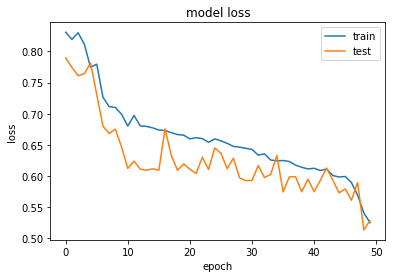

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [51]:
# model.load_weights('./model/model_02__check_point/cp-{epoch:04d}.ckpt'.format(epoch=50))
test_x, test_y, sc_parameter = create_dataset(path=paths[1844], input_days=input_days, output_days=output_days)
test_x[np.isnan(test_x)] = 0
pred = np.argmax(model.predict(test_x), axis=-1)
print(pred.shape, pred)

(461,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


(461,)


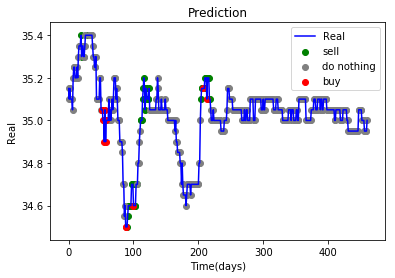

In [52]:
test_sc = MinMaxScaler()
test_sc.updatePatameter(sc_parameter)
test_real = test_x[:, -1, 0]
test_real = test_sc.getInverseData(test_real)
output_action = pred
print(test_real.shape)

# Visualising the results
plot = test_real
sell = np.where(output_action==0)
do_nothing = np.where(output_action==1)
buy = np.where(output_action==2)
plt.plot(plot, color = 'blue', label = 'Real')
plt.scatter(sell, plot[sell], color = 'green', label = 'sell')
plt.scatter(do_nothing, plot[do_nothing], color = 'gray', label = 'do nothing')
plt.scatter(buy, plot[buy], color = 'red', label = 'buy')
# plt.plot(output_prices, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()

# import env

In [16]:
from tools import stockEvn_single as single_env

env = single_env()

test_sc = MinMaxScaler()
test_sc.updatePatameter(sc_parameter)


def predict_once(index):
    info = env.getInfo()
    result = [info['assets']]
    stock_value = [info['stock value']]
    test_x, test_y, sc_parameter = create_dataset(path=paths[index], input_days=input_days, output_days=output_days)
    test_x[np.isnan(test_x)] = 0
    model_pred = model.predict(test_x)
    pred = np.argmax(model_pred, axis=-1)
    test_real = test_x[:, -1, 0]
    test_real = test_sc.getInverseData(test_real)
    output_action = pred
    for i, action in enumerate(output_action):
        env.doAction(test_real[i], action, model_pred[i, action])
        info = env.getInfo()
        result.append(info['assets'])
        stock_value.append(info['stock value'])
    env.doAction(test_real[-1], 0, 1)
    return result, stock_value

C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\DVLAB\AppData\anaconda3\envs\dlib\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


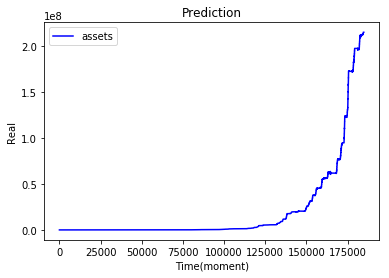

In [17]:
total_assets = np.array([])


for i in range(1501, 1901):
    assets, stock_value = predict_once(i)
    total_assets = np.append(total_assets, np.asarray(assets))

# Visualising the results
plt.plot(total_assets, color = 'blue', label = 'assets')
# plt.plot(stock_value, color = 'red', label = 'stock value')
# plt.plot(output_prices, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Prediction')
plt.xlabel('Time(moment)')
plt.ylabel('Real')
plt.legend()
plt.show()

In [23]:
print(total_assets.shape)
for price in total_assets[1:-1:1000]:
    print(price)

(184800,)
1000.0
1000.0
1001.529966329966
1076.4988995647532
1079.654455120309
1065.102950197665
1084.5713953430181
1084.5713953430181
1160.0989315749016
1417.7592955789478
1866.237593451288
2209.4822820959744
2248.931799780862
2248.931799780862
2302.6105685698913
2300.286353323255
2300.286353323255
2300.286353323255
2582.684531036529
2819.0921469648288
3279.7418691724415
3724.172667245754
4351.599980021081
4758.750053442527
4804.861937929754
5706.577174859036
6391.606608821306
6391.606608821306
6551.85378326848
6776.695660524797
6988.96224808859
6995.55179057225
6995.55179057225
7043.640866202502
7047.7361640081435
7090.898678299127
7119.455757945145
7119.455757945145
8175.020171193932
9005.01559104125
10377.066481089887
13073.836449109882
13721.207628149188
16786.635474897077
16874.013747370023
16874.013747370023
16976.662113383092
16976.662113383092
17012.711397050716
16708.318870511437
16724.007080118427
16739.695289725412
16739.695289725412
16739.695289725412
23938.92781190897
242